<a href="https://colab.research.google.com/github/JairEsc/Mat_Apl/blob/main/Opt_T9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

FR: $\beta_{k+1}^{FR}=\frac{||\nabla f(x_{k+1})||^2}{||\nabla f(x_{k})||^2}$

PR: $\beta_{k+1}^{PR}=\frac{\nabla^T f(x_{k+1})\cdot( \nabla f(x_{k+1})-\nabla f(x_k))}{||\nabla f(x_{k})||^2}$

FR-PR: $\beta_{k+1}^{FR-PR}=\left\{
	\begin{array}{ll}
		-\beta^{FR}_{k+1}, \text{ if } \beta_{k+1}^{PR}\leq -\beta_{k+1}^{FR}\\
		\beta^{PR}_{k+1}, \text{ if } |\beta_{k+1}^{PR}|\leq \beta_{k+1}^{FR}\\
		\beta^{FR}_{k+1}, \text{ if } \beta_{k+1}^{PR}> \beta_{k+1}^{FR}\\
	\end{array}
\right.$

HS $\beta_{k+1}^{HS}=\frac{\nabla^T f(x_{k+1})\cdot( \nabla f(x_{k+1})-\nabla f(x_k)}{ (\nabla f(x_{k+1})-\nabla f(x_k))^T\cdot d_k}$

General
Algorithm:
$$
d_0=-\nabla f(x_0), k=0$$
$$
while(||d_k||>tol_g):$$
$$\text{Compute } \alpha_k \text{ using line search algorithm}$$
$$\text{Update } x_{k-1}=x_k+\alpha_kd_k$$
$$\text{Compute } \nabla f(x_{k+1})$$
$$\text{Choose } \beta_{k+1} \text{ using a method.}$$
$$\text{Update } d_{k+1}=-\nabla f(x_{k+1})+\beta_{k}\cdot d_k$$
$$k=k+1$$


In [1]:
from scipy import optimize
import numpy as np

In [133]:
#Gradiente conjugado con varios metodos---------------------------------
def choose_beta(grad_f_kp1,grad_f_k,d_k,method):
    if (method=='FR'):
        return (np.dot(grad_f_kp1,grad_f_kp1-np.array(grad_f_kp1)))/(np.dot(grad_f_k,grad_f_k))
    if (method=='PR'):
        return (np.dot(grad_f_kp1,grad_f_kp1))/(np.dot(grad_f_k,grad_f_k))
    if (method=='HS'):
        return (np.dot(grad_f_kp1,grad_f_kp1-np.array(grad_f_kp1)))/(np.dot(grad_f_kp1-grad_f_k,d_k))
    if (method=='FR-PR'):
        bFR=(np.dot(grad_f_kp1,grad_f_kp1-np.array(grad_f_kp1)))/(np.dot(grad_f_k,grad_f_k))
        bPR=(np.dot(grad_f_kp1,grad_f_kp1))/(np.dot(grad_f_k,grad_f_k))
        if(abs(bPR)<=bFR):
            return bPR
        else:
            if(bPR<-bFR):
                return -bFR
            else:
                return bFR

def GC(f,grad_f,x_0,tol_g=10**(-4),max_iter=10**3,method='FR'):
    d_0=-1.*np.array(grad_f(x_0))
    g_k=-d_0
    k=0
    graficables_f=[]
    graficables_g=[]
    while(np.linalg.norm(d_0)>=tol_g and k<max_iter):
        if(k%30==0):
            print("iter:",k)
            graficables_f.append(f(x_0)) 
            graficables_g.append(np.linalg.norm(x_0))
        alpha_try=optimize.line_search(f=f,myfprime=grad_f,xk=x_0,pk=d_0,c1=0.001,c2=0.5,maxiter=10**8)[0] 
        if(alpha_try is None):
            print(type(alpha_try))
            alpha_k_gc=10**(-5)
        else:
            alpha_k_gc=alpha_try #Tam. de paso            
        x_1=x_0+alpha_k_gc*d_0 #update
        g_km1=grad_f(x_1) 
        beta_k_gc=choose_beta(grad_f_kp1=g_km1,grad_f_k=g_k,d_k=d_0,method=method)
        d_0=-np.array(g_km1)+beta_k_gc*d_0
        x_0=x_1
        k+=1
    plt.plot(graficables_f)
    plt.show()
    plt.plot(graficables_g)
    plt.show()
    print("iter",k)
    return(x_0)
#-----------------------------------

In [130]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
G=mpimg.imread('lenanoise.png')
lamb=0.5
mu=0.01
def fun_obj(X):#X es una matriz de nxn
    f=0
    nrow=X.shape[0]
    ncol=X.shape[1]
    for i in range(nrow):
        for j in range(ncol):
            f+=(X[i,j]-G[i,j])**2
            if(i==0 or i==nrow-1):
                if(i==0):
                    f+=lamb*(np.sqrt((X[i,j]-X[i+1,j])**2+mu))
                else:
                    f+=lamb*(np.sqrt((X[i,j]-X[i-1,j])**2+mu))
            else:
                f+=lamb*(np.sqrt((X[i,j]-X[i+1,j])**2+mu)+np.sqrt((X[i,j]-X[i-1,j])**2+mu))
            if(j==0 or j==ncol-1):
                if(j==0):
                    f+=lamb*(np.sqrt((X[i,j]-X[i,j+1])**2+mu))
                else:
                    f+=lamb*(np.sqrt((X[i,j]-X[i,j-1])**2+mu))
            else:
                f+=lamb*(np.sqrt((X[i,j]-X[i,j+1])**2+mu)+np.sqrt((X[i,j]-X[i,j-1])**2+mu))
    return f
def grad_f(X):#X es una matriz [i,j], lo voy a pensar como un vector con indices i*(n-1)+j
    nrow=X.shape[0]
    ncol=X.shape[1]
    grad_vect=np.zeros(nrow**2)
    for i in range(nrow):#Checar lo que pasa en las fronteras de la imagen
        for j in range(ncol):
            grad=0
            grad+=2*(X[i,j]-G[i,j])
            if(i==0 or i==nrow-1):
                if(i==0):
                    grad+=2*lamb*((X[i,j]-X[i+1,j])*(np.sqrt((X[i,j]-X[i+1,j])**2+mu)**(-1)))
                else:
                    grad+=2*lamb*((X[i,j]-X[i-1,j])*(np.sqrt((X[i,j]-X[i-1,j])**2+mu)**(-1)))
            else:
                grad+=2*lamb*((X[i,j]-X[i+1,j])*(np.sqrt((X[i,j]-X[i+1,j])**2+mu)**(-1))+(X[i,j]-X[i-1,j])*(np.sqrt((X[i,j]-X[i-1,j])**2+mu)**(-1)))
            if(j==0 or j==ncol-1):
                if(j==0):
                    grad+=2*lamb*((X[i,j]-X[i,j+1])*(np.sqrt((X[i,j]-X[i,j+1])**2+mu)**(-1)))
                else:
                    grad+=2*lamb*((X[i,j]-X[i,j-1])*(np.sqrt((X[i,j]-X[i,j-1])**2+mu)**(-1)))
            else:
                grad+=2*lamb*((X[i,j]-X[i,j+1])*(np.sqrt((X[i,j]-X[i,j+1])**2+mu)**(-1))+(X[i,j]-X[i,j-1])*(np.sqrt((X[i,j]-X[i,j-1])**2+mu)**(-1)))
            grad_vect[i*(nrow)+j]=grad  
    return grad_vect

In [44]:
def fun_obj_from_array(Y):
    Y=np.array(np.split(Y,int(np.sqrt(len(Y)))))
    return fun_obj(Y)
def grad_f_from_array(Y):
    Y=np.array(np.split(Y,int(np.sqrt(len(Y)))))
    return grad_f(Y)

In [9]:
from scipy import optimize

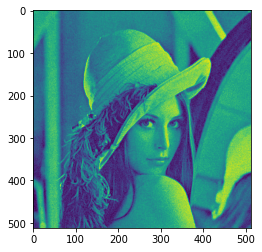

iter: 0


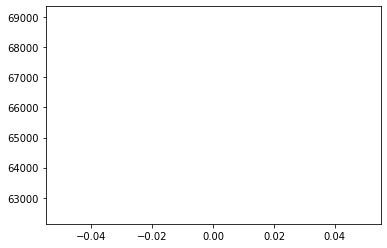

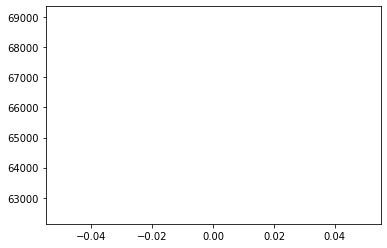

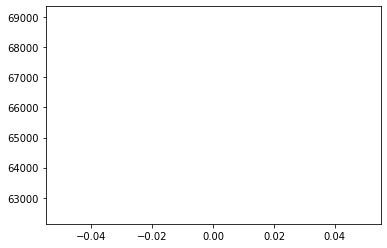

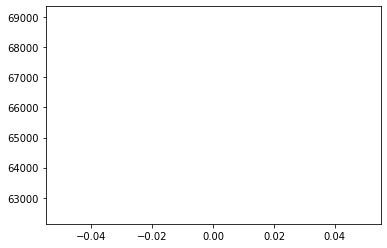

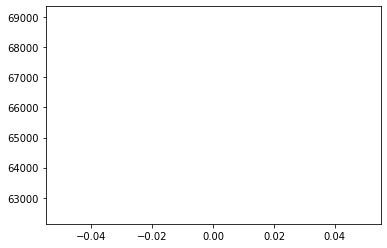

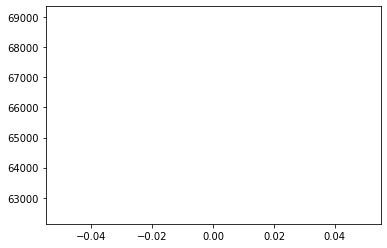

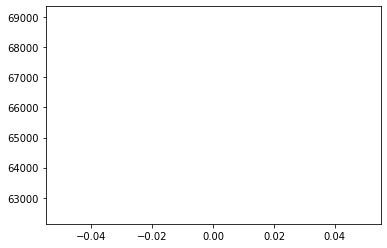

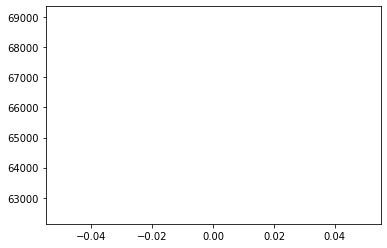

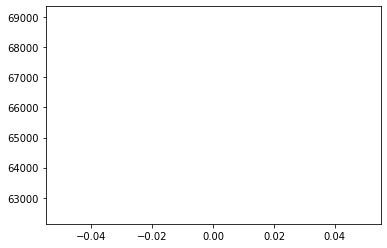

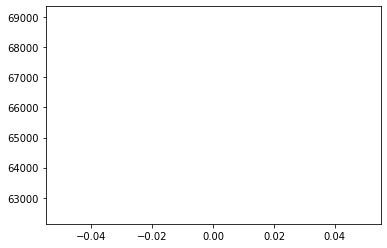

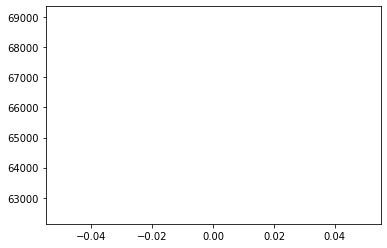

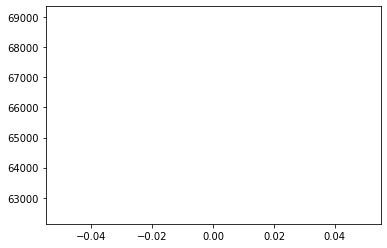

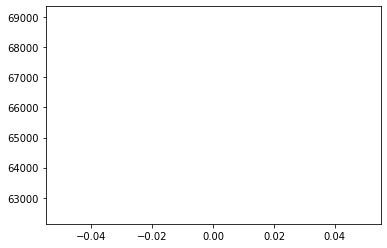

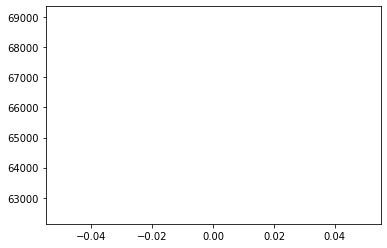

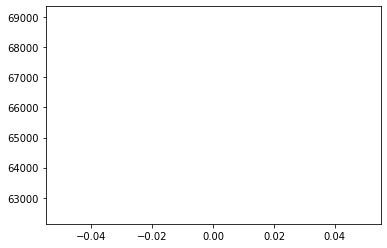

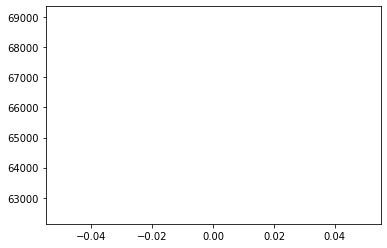

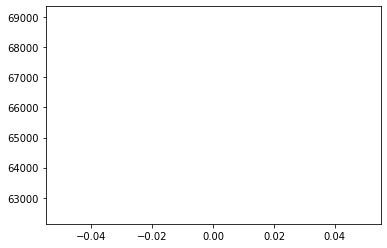

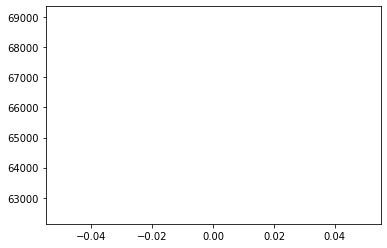

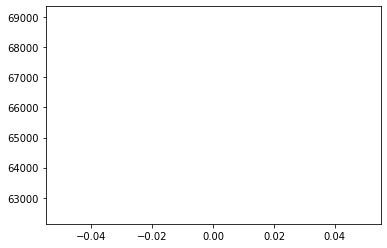

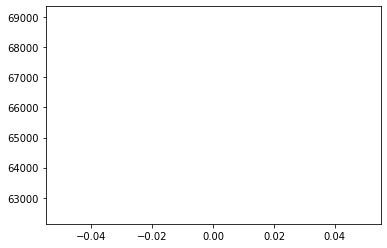

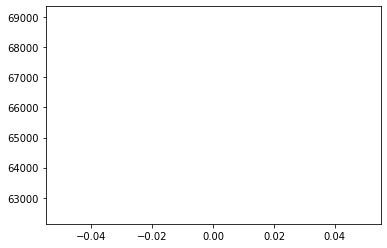

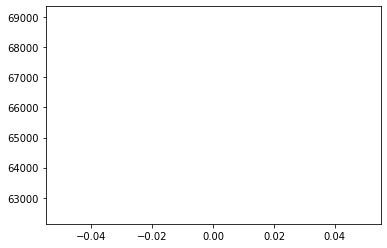

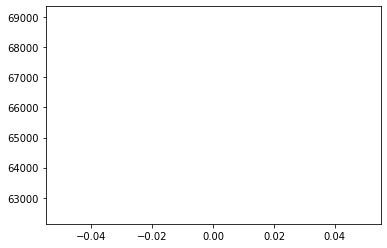

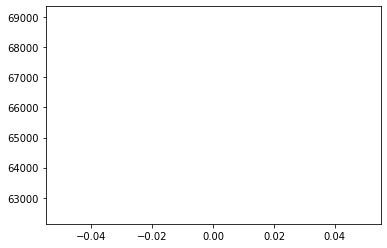

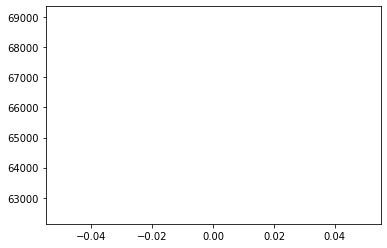

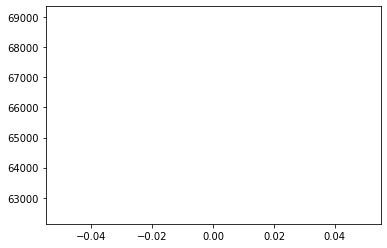

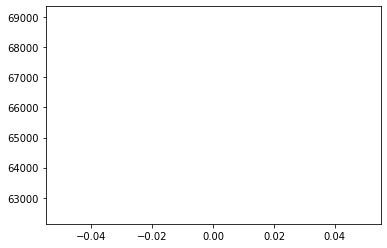

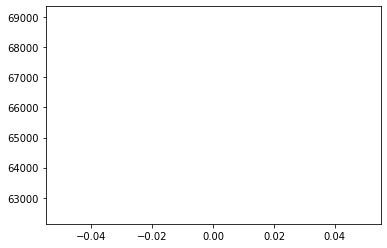

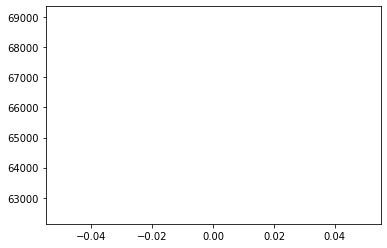

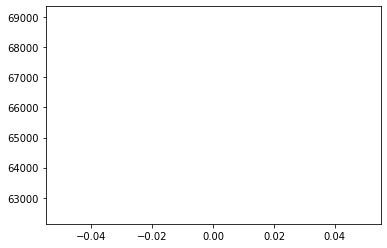

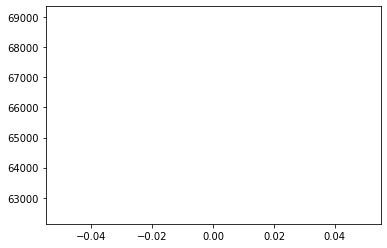

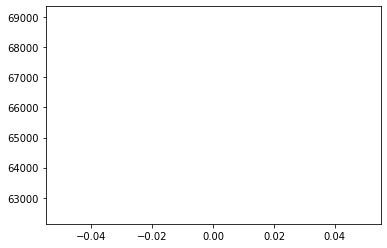

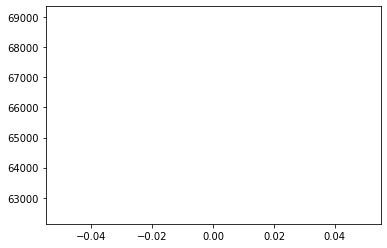

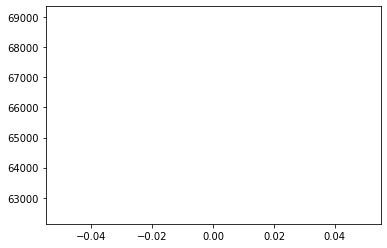

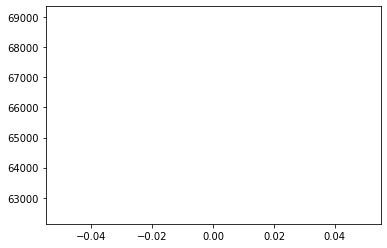

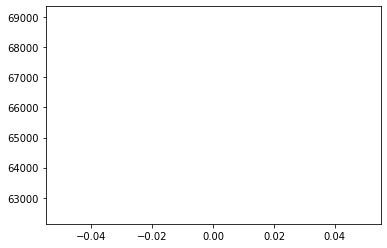

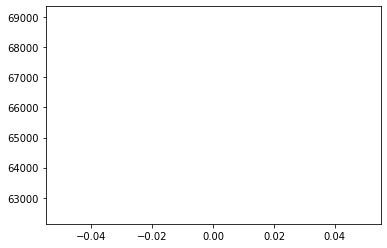

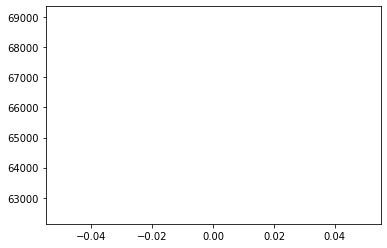

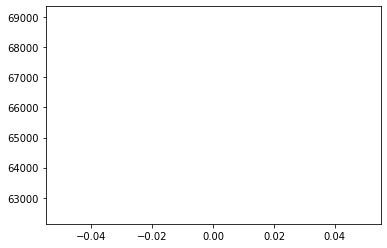

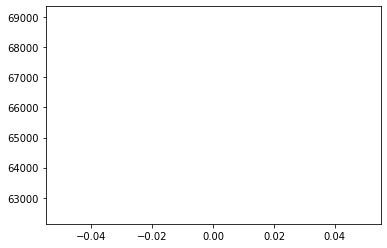

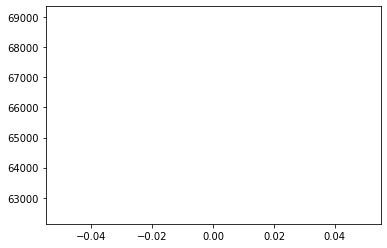

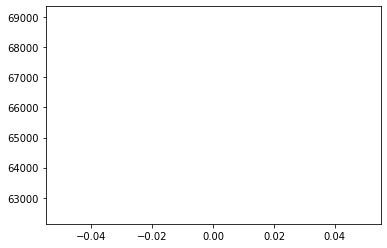

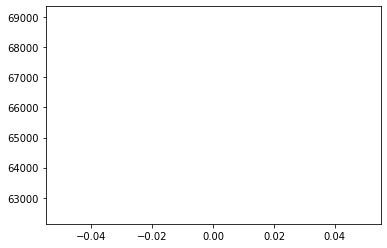

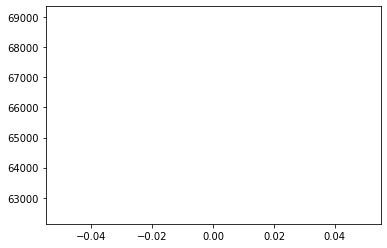

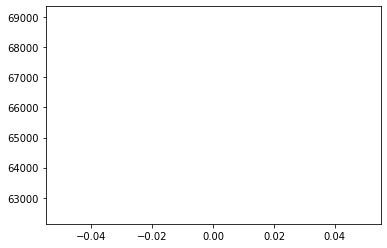

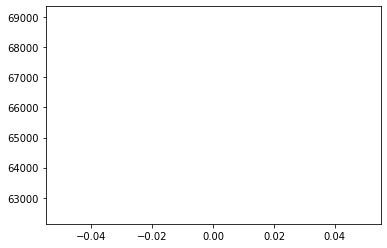

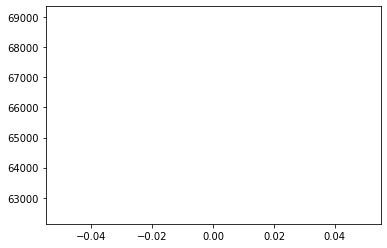

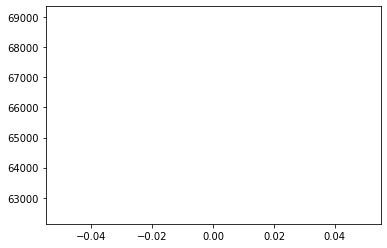

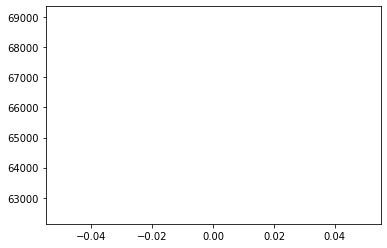

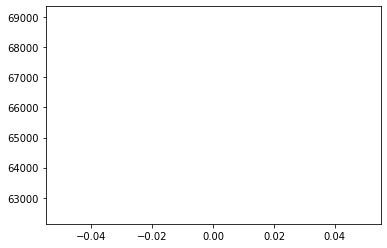

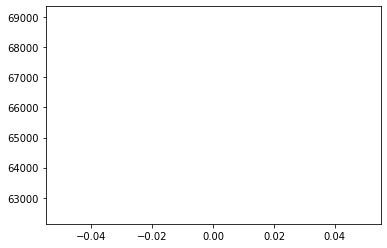

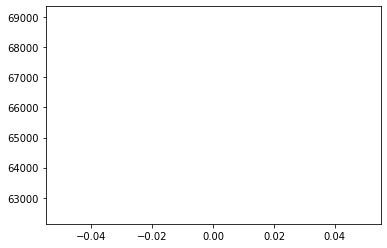

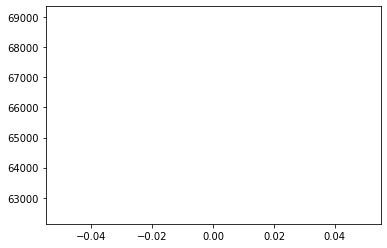

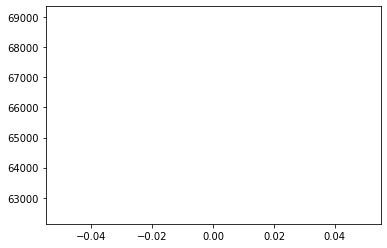

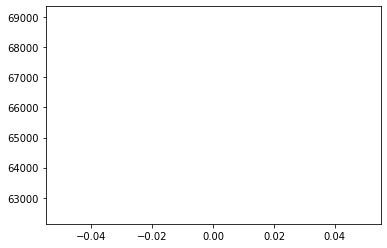

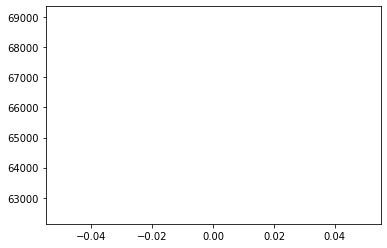

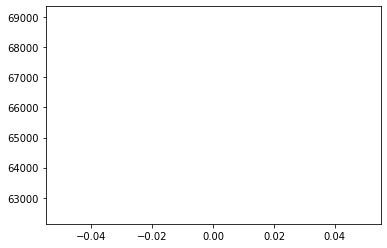

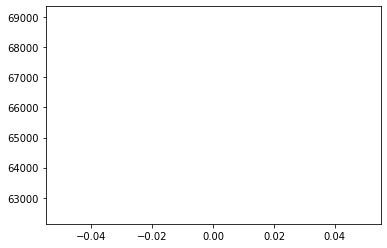

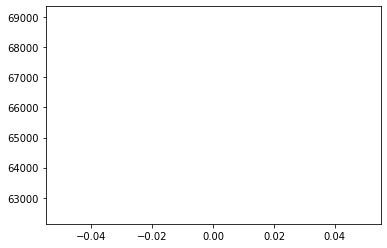

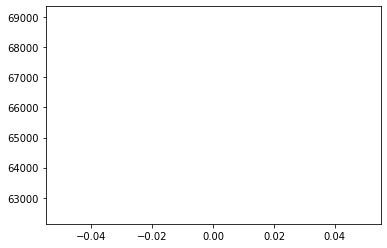

iter: 30


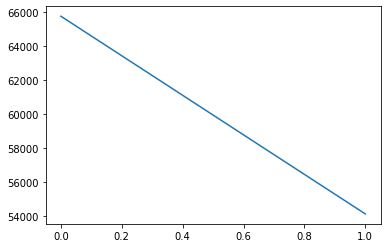

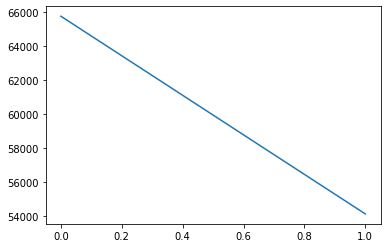

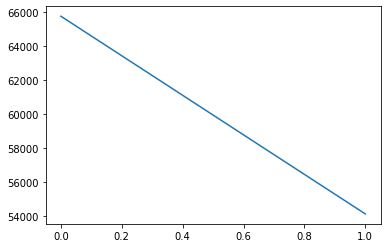

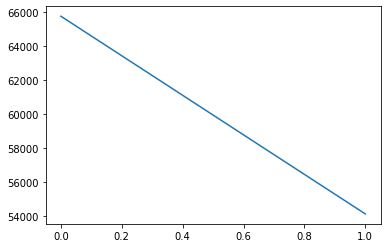

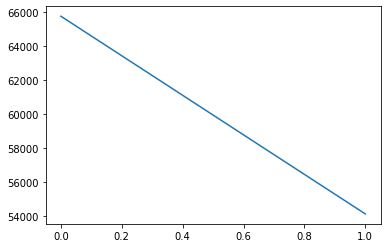

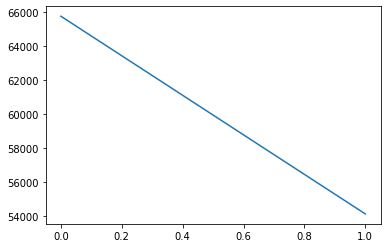

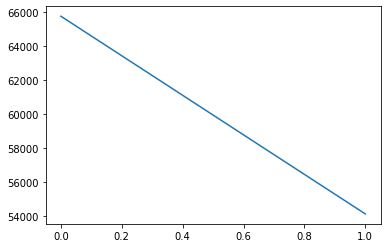

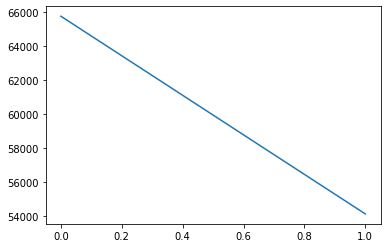

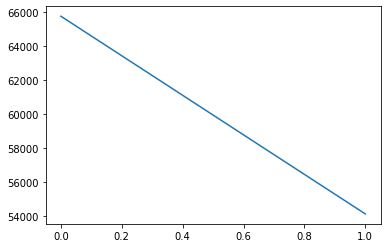

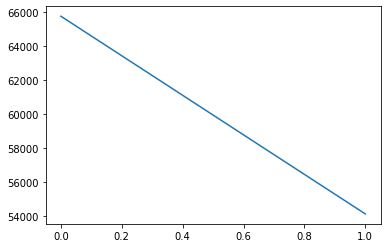

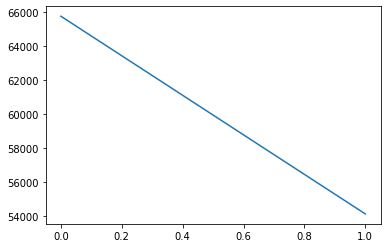

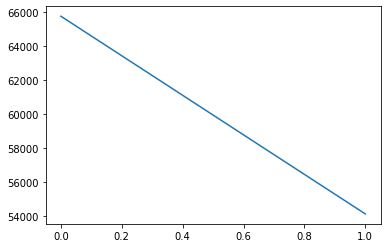

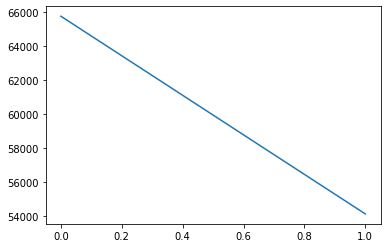

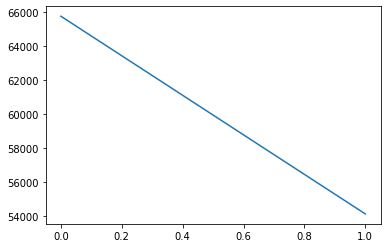

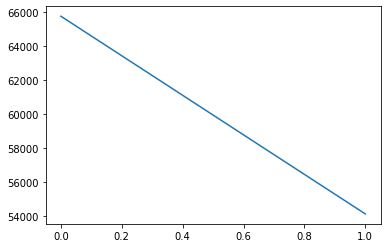

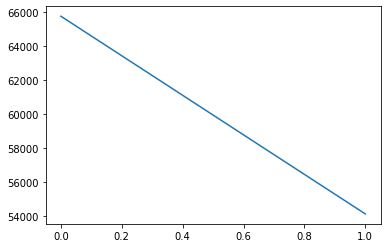

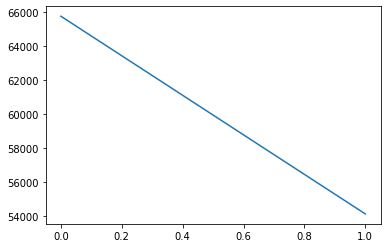

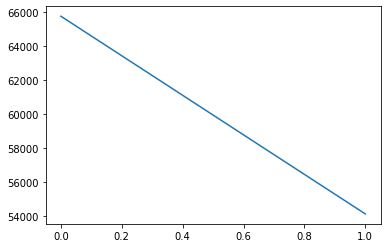

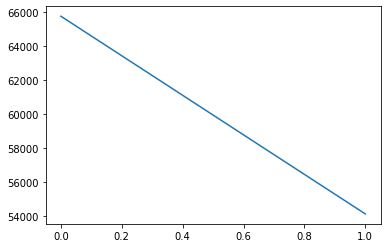

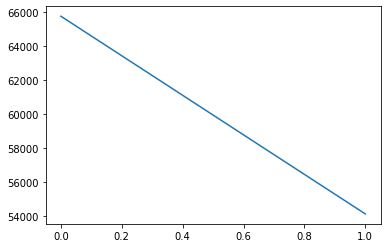

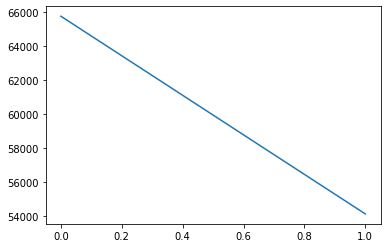

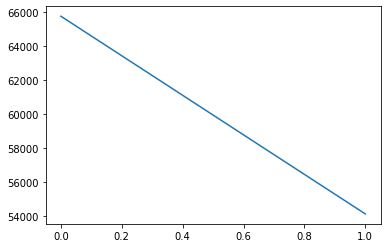

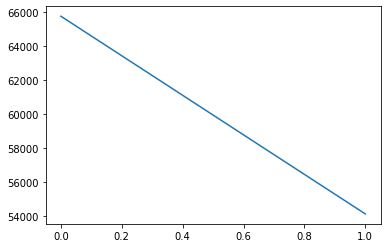

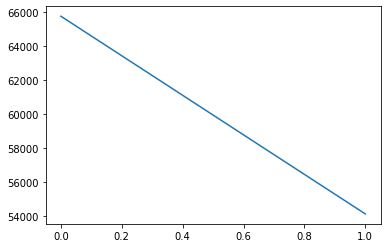

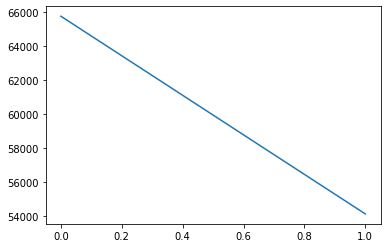

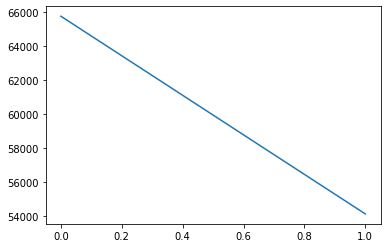

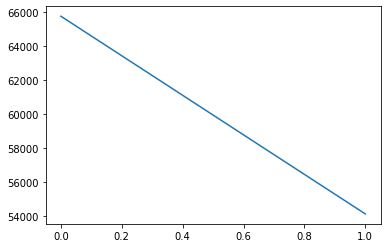

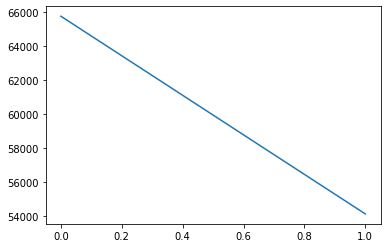

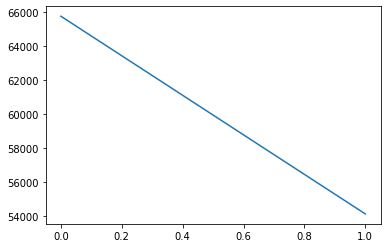

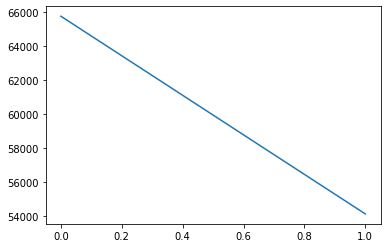

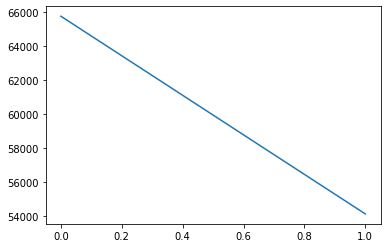

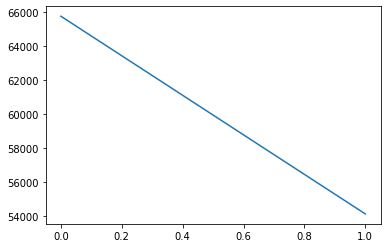

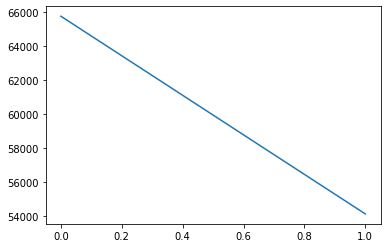

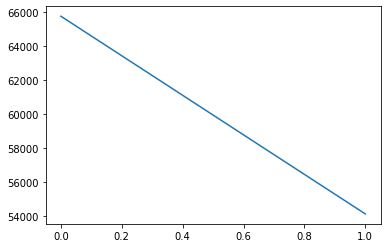

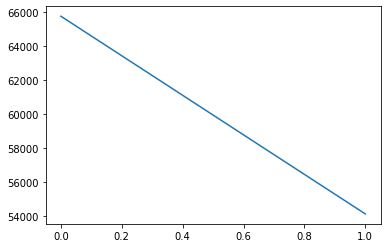

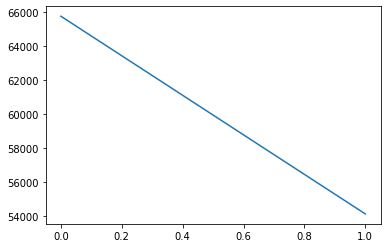

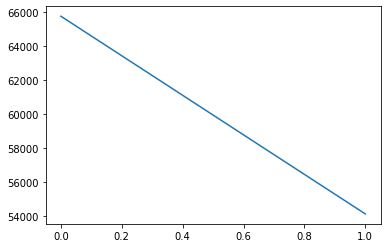

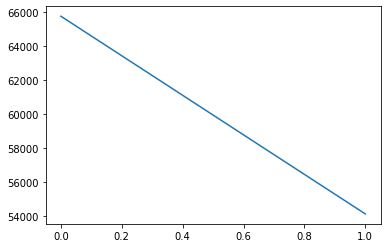

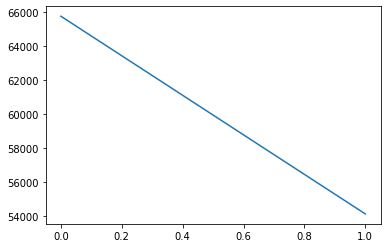

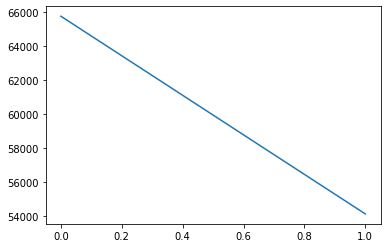

iter 50


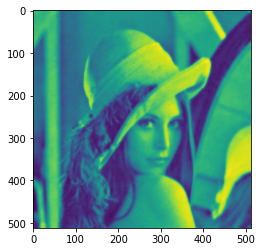

In [131]:
img = mpimg.imread('lenanoise.png',)
import cv2
import numpy as np
imgplot = plt.imshow(img)
plt.show()
res_meojorada_2=GC(f=fun_obj_from_array,grad_f=grad_f_from_array,x_0=np.concatenate(img),max_iter=50,)
imgplot = plt.imshow(np.split(res_meojorada_2,512))
plt.show()

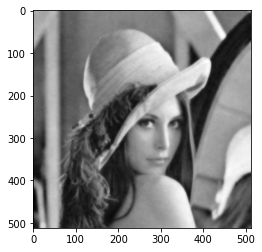

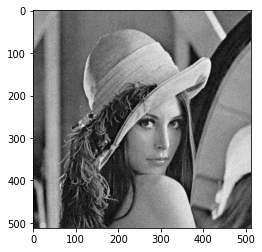

In [132]:
imgplot = plt.imshow(np.split(res_meojorada_2,512),cmap='gray')
plt.show()
imgplot2 = plt.imshow(img,cmap='gray')


In [115]:
print(res)

[[0.63529414 0.64705884 0.74509805 ... 0.7294118  0.60784316 0.54509807]
 [0.6431373  0.6156863  0.6156863  ... 0.6        0.7058824  0.44313726]
 [0.59607846 0.6        0.59607846 ... 0.6666667  0.5647059  0.52156866]
 ...
 [0.08235294 0.03921569 0.10980392 ... 0.34509805 0.40392157 0.34117648]
 [0.1254902  0.03137255 0.16470589 ... 0.35686275 0.36862746 0.47058824]
 [0.         0.09019608 0.14117648 ... 0.3647059  0.3764706  0.32156864]]


In [119]:
print(np.max(np.split(res_meojorada_1,512)-res))

0.22441937962368064
